In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('ds_salaries.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


In [15]:
#Pattern Mining
import numpy as np
df = pd.read_csv("ds_salaries.csv")
experience_mapping = {'EN': 0, 'MI': 1, 'SE': 2, 'EX': 3}
size_mapping = {'S': 0, 'M': 1, 'L': 2}

df['exp_num'] = df['experience_level'].map(experience_mapping)
df['size_num'] = df['company_size'].map(size_mapping)

features = df[['salary_in_usd', 'work_year', 'remote_ratio', 'exp_num', 'size_num']].dropna()

correlation_matrix = features.corr().round(2)
from IPython.display import display

display(
    correlation_matrix.style
    .set_caption("Main Correlation Matrix")
    .set_properties(**{
        'border': '1px solid black',
        'text-align': 'center',
        'padding': '6px'
    })
)

,salary_in_usd,work_year,remote_ratio,exp_num,size_num
salary_in_usd,1.000000,0.170000,0.130000,0.480000,0.150000
work_year,0.170000,1.000000,0.080000,0.290000,-0.080000
remote_ratio,0.130000,0.080000,1.000000,0.100000,-0.020000
exp_num,0.480000,0.290000,0.100000,1.000000,0.060000
size_num,0.150000,-0.080000,-0.020000,0.060000,1.000000


In [13]:
#Clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from IPython.display import display

df = pd.read_csv('ds_salaries.csv')

features = df[['salary_in_usd', 'work_year', 'remote_ratio']].copy()

experience_mapping = {'EN': 0, 'MI': 1, 'SE': 2, 'EX': 3}
features['experience_level_num'] = df['experience_level'].map(experience_mapping)

features = features.dropna()

X = features[['salary_in_usd', 'work_year', 'remote_ratio', 'experience_level_num']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
features['cluster'] = kmeans.fit_predict(X_scaled)

cluster_summary = features.groupby('cluster').agg(
    Number_of_Records=('salary_in_usd', 'count'),
    Average_Salary_USD=('salary_in_usd', 'mean'),
    Average_Work_Year=('work_year', 'mean'),
    Average_Remote_Ratio=('remote_ratio', 'mean'),
    Average_Experience_Level=('experience_level_num', 'mean')
).round(2).reset_index()   # <-- thêm reset_index()

display(cluster_summary.style.format({
    'Average_Salary_USD': '{:,.0f}',
    'Average_Work_Year': '{:.0f}',
    'Average_Remote_Ratio': '{:.1f}',
    'Average_Experience_Level': '{:.1f}'
}).set_caption("Cluster Summary"))

,cluster,Number_of_Records,Average_Salary_USD,Average_Work_Year,Average_Remote_Ratio,Average_Experience_Level
0,0,298,"67,523",2021,62.6,0.8
1,1,309,"155,479",2022,79.0,2.0


In [6]:
cluster_0_examples = df[features['cluster'] == 0].head()
cluster_1_examples = df[features['cluster'] == 1].head()

display(cluster_0_examples[['job_title', 'salary_in_usd', 'company_location', 'remote_ratio', 'experience_level']]
        .style.set_caption("Example Records for Cluster 0"))

display(cluster_1_examples[['job_title', 'salary_in_usd', 'company_location', 'remote_ratio', 'experience_level']]
        .style.set_caption("Example Records for Cluster 1"))

,job_title,salary_in_usd,company_location,remote_ratio,experience_level
0,Data Scientist,79833,DE,0,MI
2,Big Data Engineer,109024,GB,50,SE
3,Product Data Analyst,20000,HN,0,MI
4,Machine Learning Engineer,150000,US,50,SE
5,Data Analyst,72000,US,100,EN


,job_title,salary_in_usd,company_location,remote_ratio,experience_level
1,Machine Learning Scientist,260000,JP,0,SE
6,Lead Data Scientist,190000,US,100,SE
25,Director of Data Science,325000,US,100,EX
33,Research Scientist,450000,US,0,MI
41,Data Engineering Manager,79833,ES,50,EX


In [14]:
from IPython.display import display_html
df = pd.read_csv("ds_salaries.csv")
# Common job roles
job_group = df.groupby('job_title').agg(
    Count=('salary_in_usd', 'count'),
    Average_Salary_USD=('salary_in_usd', 'mean')
).sort_values('Count', ascending=False).head(3).reset_index()
job_table = job_group.style.format({'Average_Salary_USD': '{:,.0f}'}).set_caption("Top 3 Job Roles")
display(job_table)

,job_title,Count,Average_Salary_USD
0,Data Scientist,143,"108,188"
1,Data Engineer,132,"112,725"
2,Data Analyst,97,"92,893"


In [2]:
!pip install xgboost



   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.5/56.8 MB 1.3 MB/s eta 0:00:44
   ---------------------------------------- 0.5/56.8 MB 1.3 MB/s eta 0:00:44
    --------------------------------------- 0.8/56.8 MB 1.2 MB/s eta 0:00:47
    --------------------------------------- 1.0/56.8 MB 1.1 MB/s eta 0:00:50
    --------------------------------------- 1.3/56.8 MB 1.1 MB/s eta 0:00:52
   - -------------------------------------- 1.6/56.8 MB 1.1 MB/s eta 0:00:50
   - -------------------------------------- 2.1/56.8 MB 1.3 MB/s eta 0:00:44
   - -------------------------------------- 2.4/56.8 MB 1.3 MB/s eta 0:00:42
   -- ------------------------------------- 2.9/56.8 MB 1.4 MB/s eta 0:00:38
   -- ------------------------------------- 3.1/56.8 MB 1.5 MB/s eta 0:00:37
   -- ------------------------------------- 3.7/56.8 MB 1.5 MB/s eta 0:00:35
   -- -------

In [18]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

df = pd.read_csv("ds_salaries.csv")

X = df[['work_year','experience_level','employment_type','job_title',
        'employee_residence','remote_ratio','company_location','company_size']]
y = df['salary_in_usd']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(exclude=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42))
])

param_grid = {
    'model__n_estimators': [200, 300, 500],
    'model__learning_rate': [0.05, 0.1, 0.2],
    'model__max_depth': [4, 6, 8],
    'model__subsample': [0.7, 0.8, 1.0],
    'model__colsample_bytree': [0.7, 0.8, 1.0]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("XGBoost with GridSearchCV:")
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__n_estimators': 200, 'model__subsample': 0.7}
XGBoost with GridSearchCV:
MAE: 27426.392578125
RMSE: 41060.27569318063
R²: 0.5601001977920532


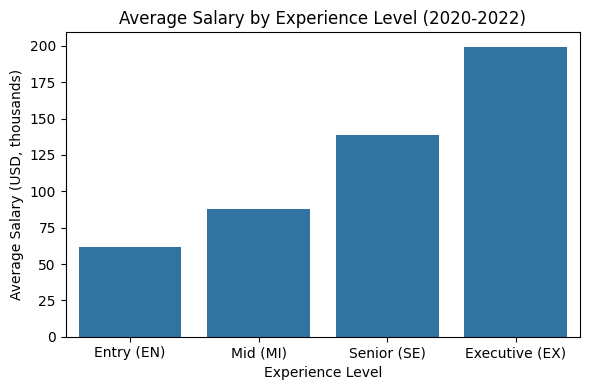

In [19]:
# Salary by experience level
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('ds_salaries.csv')
plt.figure(figsize=(6, 4))
avg_salary_exp = df.groupby('experience_level')['salary_in_usd'].mean().reset_index()
avg_salary_exp['salary_in_usd'] = avg_salary_exp['salary_in_usd'] / 1000  # Convert to thousands
sns.barplot(x='experience_level', y='salary_in_usd', data=avg_salary_exp, order=['EN', 'MI', 'SE', 'EX'])
plt.title('Average Salary by Experience Level (2020-2022)')
plt.xlabel('Experience Level')
plt.ylabel('Average Salary (USD, thousands)')
plt.xticks(ticks=range(4), labels=['Entry (EN)', 'Mid (MI)', 'Senior (SE)', 'Executive (EX)'])
plt.tight_layout()
plt.show()

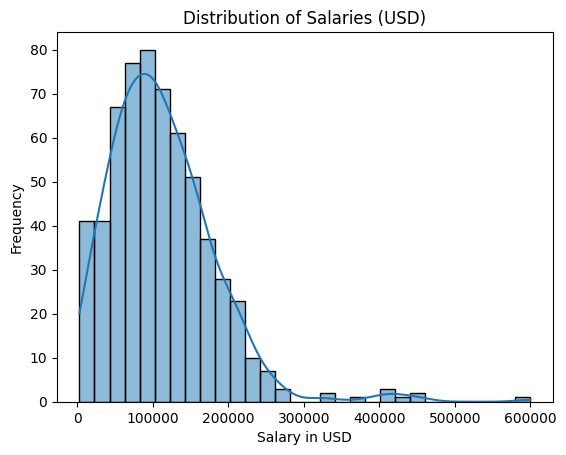

In [5]:
plt.figure()
sns.histplot(df["salary_in_usd"], bins=30, kde=True)
plt.title("Distribution of Salaries (USD)")
plt.xlabel("Salary in USD")
plt.ylabel("Frequency")
plt.show()

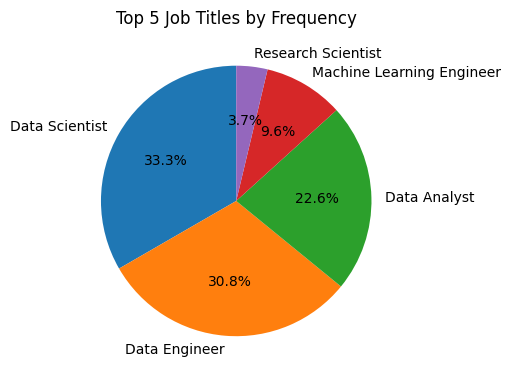

In [6]:
####Salary by job title
plt.figure(figsize=(5, 5))
top_jobs = df['job_title'].value_counts().head(5)
plt.pie(top_jobs.values, labels=top_jobs.index, autopct='%1.1f%%', startangle=90)
plt.title('Top 5 Job Titles by Frequency')
plt.tight_layout()
plt.show()

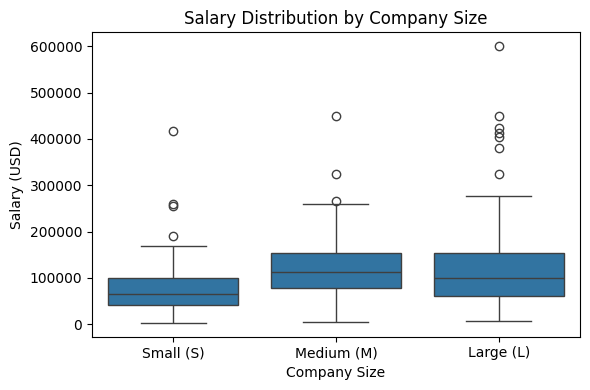

In [7]:
####Salary by company size
plt.figure(figsize=(6, 4))
sns.boxplot(x='company_size', y='salary_in_usd', data=df, order=['S', 'M', 'L'])
plt.title('Salary Distribution by Company Size')
plt.xlabel('Company Size')
plt.ylabel('Salary (USD)')
plt.xticks(ticks=range(3), labels=['Small (S)', 'Medium (M)', 'Large (L)'])
plt.tight_layout()
plt.show()

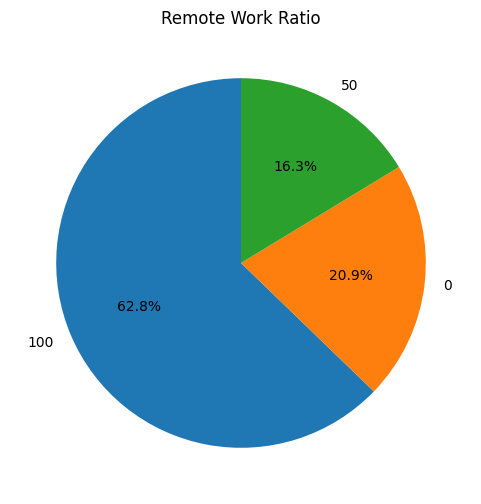

In [8]:
remote_counts = df["remote_ratio"].value_counts()

plt.figure(figsize=(6,6))
plt.pie(remote_counts, labels=remote_counts.index, autopct="%1.1f%%", startangle=90)
plt.title("Remote Work Ratio")
plt.show()

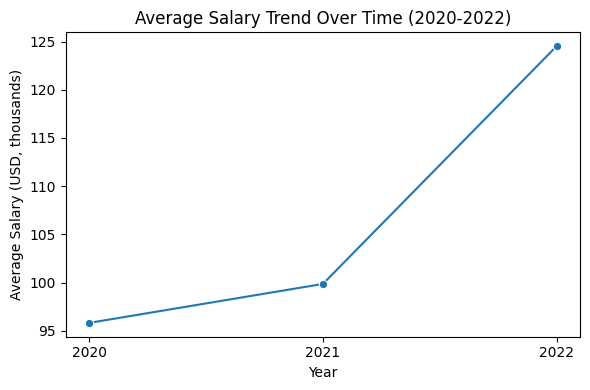

In [9]:
plt.figure(figsize=(6, 4))
avg_salary_year = df.groupby('work_year')['salary_in_usd'].mean().reset_index()
avg_salary_year['salary_in_usd'] = avg_salary_year['salary_in_usd'] / 1000
sns.lineplot(x='work_year', y='salary_in_usd', data=avg_salary_year, marker='o')
plt.title('Average Salary Trend Over Time (2020-2022)')
plt.xlabel('Year')
plt.ylabel('Average Salary (USD, thousands)')
plt.xticks([2020, 2021, 2022])
plt.tight_layout()
plt.show()

In [21]:

# Calculate salary statistics
salary_stats = {
    "Average_Salary_USD": df['salary_in_usd'].mean(),
    "Median_Salary_USD": df['salary_in_usd'].median(),
    "Min_Salary_USD": df['salary_in_usd'].min(),
    "Max_Salary_USD": df['salary_in_usd'].max()
}


salary_df = pd.DataFrame([salary_stats])
salary_df = salary_df.round(2)  # làm tròn 2 chữ số thập phân

from IPython.display import display
display(salary_df.style.set_caption("Salary Statistics in USD"))

,Average_Salary_USD,Median_Salary_USD,Min_Salary_USD,Max_Salary_USD
0,112297.870000,101570.000000,2859,600000


In [20]:


# Estimated range 25% - 75% (IQR)
q1 = df['salary_in_usd'].quantile(0.25)
q3 = df['salary_in_usd'].quantile(0.75)

# Estimated 10% - 90%
p10 = df['salary_in_usd'].quantile(0.10)
p90 = df['salary_in_usd'].quantile(0.90)

print(f"Most salaries fall between {q1:.0f} and {q3:.0f} USD (IQR 25%–75%).")
print(f"Or more broadly, between {p10:.0f} and {p90:.0f} USD (10%–90%).")


Most salaries fall between 62726 and 150000 USD (IQR 25%–75%).
Or more broadly, between 33689 and 200000 USD (10%–90%).


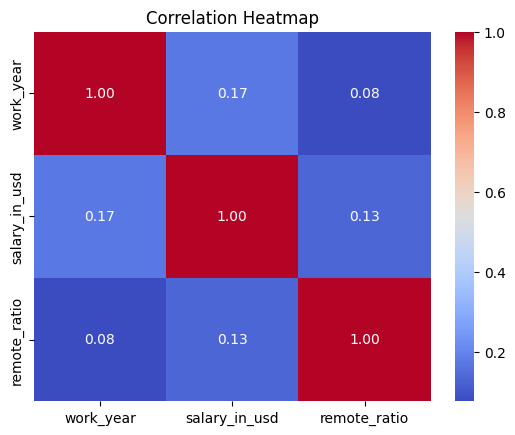

In [12]:
plt.figure()
numeric_df = df[["work_year", "salary_in_usd", "remote_ratio"]]
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

<Axes: >

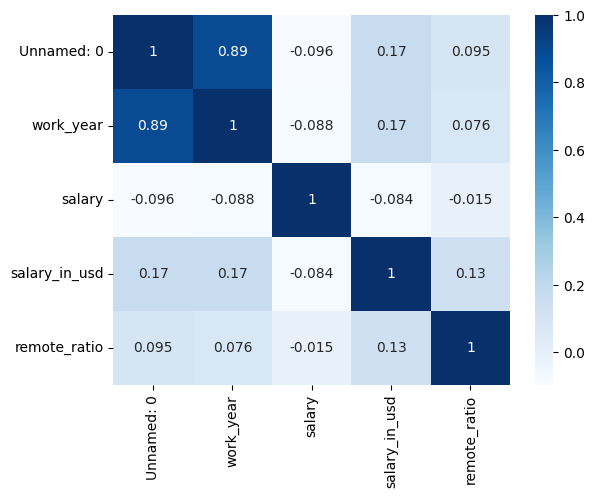

In [22]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Blues')

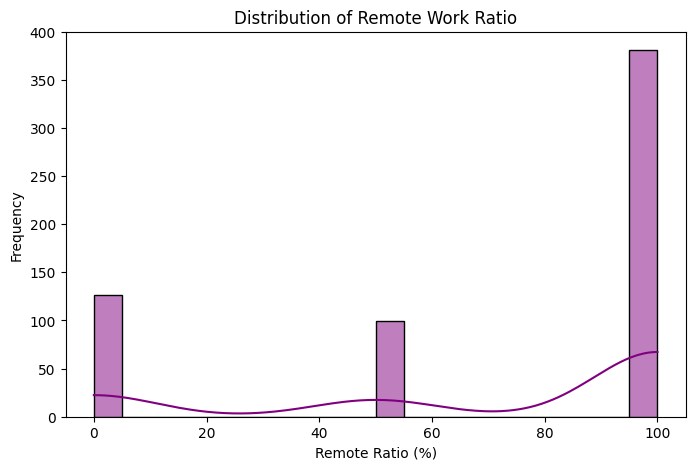

In [26]:
plt.figure(figsize=(8,5))
sns.histplot(df['remote_ratio'], bins=20, kde=True, color='purple')
plt.title('Distribution of Remote Work Ratio')
plt.xlabel('Remote Ratio (%)')
plt.ylabel('Frequency')
plt.show()

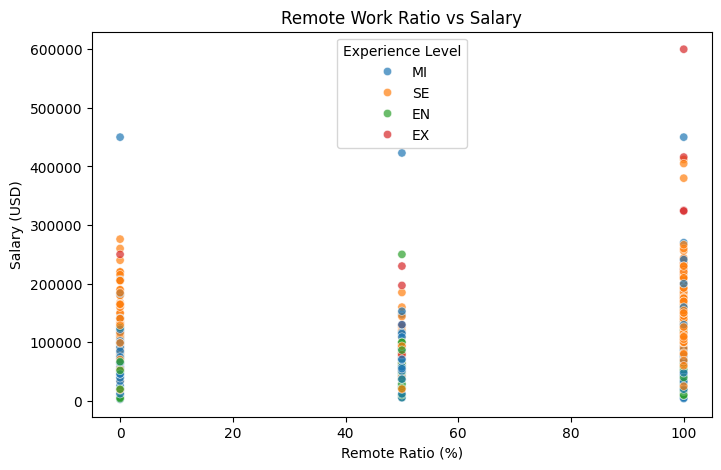

In [28]:
# Remote ratio vs salary, colored by experience
plt.figure(figsize=(8,5))
sns.scatterplot(x='remote_ratio', y='salary_in_usd', hue='experience_level', data=df, alpha=0.7)
plt.title('Remote Work Ratio vs Salary')
plt.xlabel('Remote Ratio (%)')
plt.ylabel('Salary (USD)')
plt.legend(title='Experience Level')
plt.show()

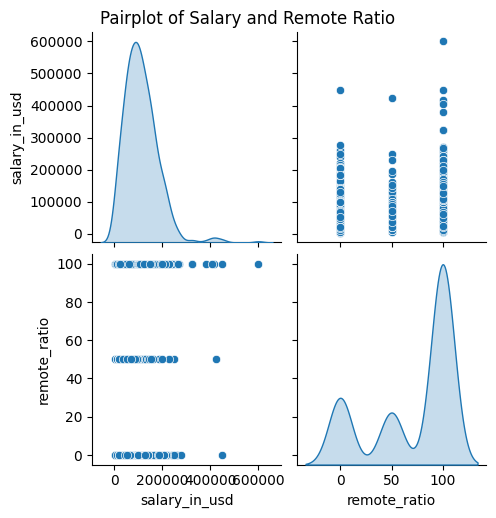

In [31]:
sns.pairplot(df[['salary_in_usd','remote_ratio']], diag_kind='kde')
plt.suptitle('Pairplot of Salary and Remote Ratio', y=1.02)
plt.show()